In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

rankings = pd.read_csv('../Data/fifa_ranking.csv')
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'cur_year_avg_weighted', 'rank_date', 
                           'two_year_ago_weighted', 'three_year_ago_weighted']]
rankings = rankings.replace({"IR Iran": "Iran"})
rankings['weighted_points'] =  rankings['cur_year_avg_weighted'] + rankings['two_year_ago_weighted'] + rankings['three_year_ago_weighted']
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

matches = pd.read_csv('../Data/results.csv')
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

world_cup = pd.read_csv('../Data/World Cup 2018 Dataset.csv')
world_cup = world_cup.loc[:, ['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]
world_cup = world_cup.dropna(how='all')
world_cup = world_cup.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})
world_cup = world_cup.set_index('Team')

In [5]:
# I want to have the ranks for every day 
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

# join the ranks
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

In [6]:
matches.head()

date home_team     away_team  home_score  away_score  \
0 1993-08-08   Bolivia       Uruguay           3           1   
1 1993-08-08    Brazil        Mexico           1           1   
2 1993-08-08   Ecuador     Venezuela           5           0   
3 1993-08-08    Guinea  Sierra Leone           1           0   
4 1993-08-08  Paraguay     Argentina           1           3   

                     tournament      city   country  neutral rank_date_home  \
0  FIFA World Cup qualification    La Paz   Bolivia    False     1993-08-08   
1                      Friendly    Maceió    Brazil    False     1993-08-08   
2  FIFA World Cup qualification     Quito   Ecuador    False     1993-08-08   
3                      Friendly   Conakry    Guinea    False     1993-08-08   
4  FIFA World Cup qualification  Asunción  Paraguay    False     1993-08-08   

          ...           three_year_ago_weighted_home weighted_points_home  \
0         ...                                    0.0                  0.0   
1         ...                                    0.0                  0.0   
2         ...                                    0.0                  0.0   
3         ...                                    0.0                  0.0   
4         ...                                    0.0                  0.0   

  rank_date_away  rank_away  country_full_away  country_abrv_away  \
0     1993-08-08       22.0            Uruguay                URU   
1     1993-08-08       14.0             Mexico                MEX   
2     1993-08-08       94.0          Venezuela                VEN   
3     1993-08-08       86.0       Sierra Leone                SLE   
4     1993-08-08        5.0          Argentina                ARG   

   cur_year_avg_weighted_away two_year_ago_weighted_away  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         0.0                        0.0   
3                         0.0                        0.0   
4                         0.0                        0.0   

   three_year_ago_weighted_away weighted_points_away  
0                           0.0                  0.0  
1                           0.0                  0.0  
2                           0.0                  0.0  
3                           0.0                  0.0  
4                           0.0                  0.0  

[5 rows x 25 columns]

In [7]:
matches.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18479 entries, 0 to 18478
Data columns (total 25 columns):
date                            18479 non-null datetime64[ns]
home_team                       18479 non-null object
away_team                       18479 non-null object
home_score                      18479 non-null int64
away_score                      18479 non-null int64
tournament                      18479 non-null object
city                            18479 non-null object
country                         18479 non-null object
neutral                         18479 non-null bool
rank_date_home                  18479 non-null datetime64[ns]
rank_home                       18479 non-null float64
country_full_home               18479 non-null object
country_abrv_home               18479 non-null object
cur_year_avg_weighted_home      18479 non-null float64
two_year_ago_weighted_home      18479 non-null float64
three_year_ago_weighted_home    18479 non-null float64
weighted_po

In [8]:
# feature generation
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['point_difference'] = matches['weighted_points_home'] - matches['weighted_points_away']
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['is_won'] = matches['score_difference'] > 0 # take draw as lost
matches['is_stake'] = matches['tournament'] != 'Friendly'

# I tried earlier rest days but it did not turn to be useful
max_rest = 30
matches['rest_days'] = matches.groupby('home_team').diff()['date'].dt.days.clip(0,max_rest).fillna(max_rest)

# I tried earlier the team as well but that did not make a difference either
matches['wc_participant'] = matches['home_team'] * matches['home_team'].isin(world_cup.index.tolist())
matches['wc_participant'] = matches['wc_participant'].replace({'':'Other'})
matches = matches.join(pd.get_dummies(matches['wc_participant']))

   average_rank  rank_difference  point_difference  is_stake
0          40.5             37.0               0.0      True
1          11.0             -6.0               0.0     False
2          64.5            -59.0               0.0      True
3          75.5            -21.0               0.0     False
4          36.0             62.0               0.0      True
0     True
1    False
2     True
3     True
4    False
Name: is_won, dtype: bool
test dataset performance: 
[[1310  598]
 [ 578 1210]]
train dataset performance: 
[[5238 2384]
 [2414 4747]]


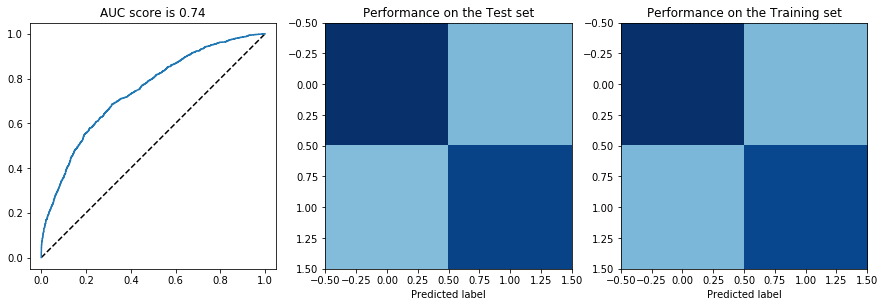

In [9]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline

X, y = matches.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches['is_won']
print(X[:5])
print(y[:5])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)
model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])
model = model.fit(X_train, y_train)

# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
print("test dataset performance: ")
print(cm)
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
print("train dataset performance: ")
print(cm)
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass

In [10]:
# let's define a small margin when we safer to predict draw then win
margin = 0.05

# let's define the rankings at the time of the World Cup
world_cup_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) & 
                                    rankings['country_full'].isin(world_cup.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])

In [11]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

world_cup['points'] = 0
world_cup['total_prob'] = 0

for group in set(world_cup['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(world_cup.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        world_cup.loc[home, 'total_prob'] += home_win_prob
        world_cup.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            world_cup.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            world_cup.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            world_cup.loc[home, 'points'] += 1
            world_cup.loc[away, 'points'] += 1

___Starting group F:___
Germany vs. Mexico: Germany wins with 0.60
Germany vs. Sweden: Germany wins with 0.63
Germany vs. Korea Republic: Germany wins with 0.71
Mexico vs. Sweden: Draw
Mexico vs. Korea Republic: Mexico wins with 0.68
Sweden vs. Korea Republic: Sweden wins with 0.64
___Starting group G:___
Belgium vs. Panama: Belgium wins with 0.73
Belgium vs. Tunisia: Belgium wins with 0.61
Belgium vs. England: Belgium wins with 0.57
Panama vs. Tunisia: Tunisia wins with 0.73
Panama vs. England: England wins with 0.77
Tunisia vs. England: England wins with 0.57
___Starting group E:___
Brazil vs. Switzerland: Draw
Brazil vs. Costa Rica: Brazil wins with 0.62
Brazil vs. Serbia: Brazil wins with 0.67
Switzerland vs. Costa Rica: Switzerland wins with 0.59
Switzerland vs. Serbia: Switzerland wins with 0.65
Costa Rica vs. Serbia: Draw
___Starting group B:___
Portugal vs. Spain: Draw
Portugal vs. Morocco: Portugal wins with 0.68
Portugal vs. Iran: Portugal wins with 0.67
Spain vs. Morocco: Sp

In [12]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = world_cup.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points

        home_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Uruguay vs. Spain: Spain wins with probability 0.54
Denmark vs. Croatia: Denmark wins with probability 0.55
Brazil vs. Mexico: Brazil wins with probability 0.58
Belgium vs. Colombia: Belgium wins with probability 0.59
Egypt vs. Portugal: Portugal wins with probability 0.81
France vs. Argentina: Argentina wins with probability 0.53
Switzerland vs. Germany: Germany wins with probability 0.60
England vs. Poland: Poland wins with probability 0.53


___Starting of the quarterfinal___
Spain vs. Denmark: Denmark wins with probability 0.51
Brazil vs. Belgium: Belgium wins with probability 0.51
Portugal vs. Argentina: Portugal wins with probability 0.51
Germany vs. Poland: Germany wins with probability 0.57


___Starting of the semifinal___
Denmark vs. Belgium: Belgium wins with probability 0.57
Portugal vs. Germany: Germany wins with probability 0.56


___Starting of the final___
Belgium vs. Germany: Germany wins with probability 0.54


